In [1]:

import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## 데이터 읽어오기.## 데이터 읽어오기.
raw_df = pd.read_csv("../dataset/house_price_of_unit_area.csv")
print(raw_df.info())
print(raw_df.head())

## data copy
dataset=raw_df.copy()




1 Physical GPUs, 1 Logical GPUs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   house age                            414 non-null    float64
 1   distance to the nearest MRT station  414 non-null    float64
 2   number of convenience stores         414 non-null    int64  
 3   latitude                             414 non-null    float64
 4   longitude                            414 non-null    float64
 5   house price of unit area             414 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 19.5 KB
None
   house age  distance to the nearest MRT station  \
0       32.0                             84.87882   
1       19.5                            306.59470   
2       13.3                            561.98450   
3       13.3                            561.98450   
4        5.0   

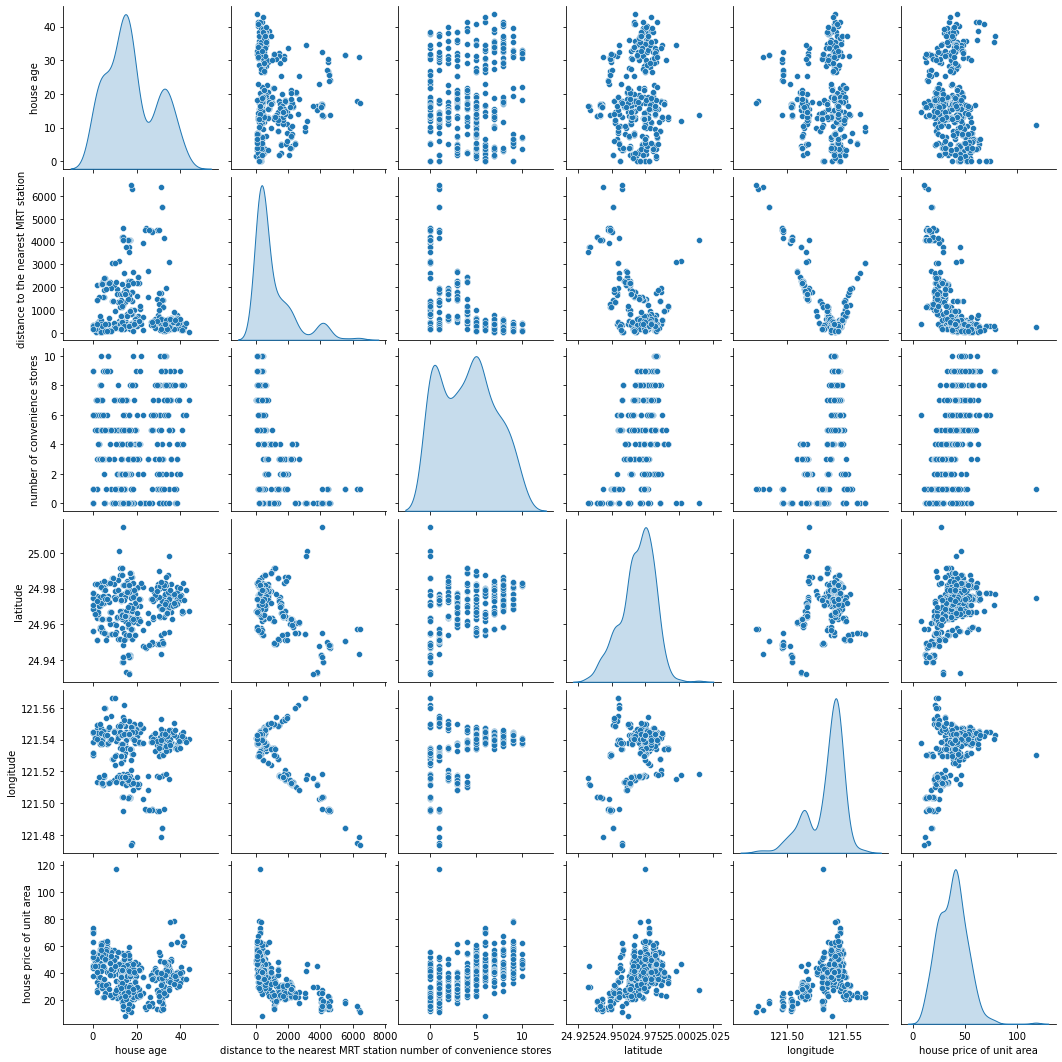

In [2]:

## data 분포도 확인
sns.pairplot(dataset[["house age", "distance to the nearest MRT station", "number of convenience stores", "latitude", "longitude","house price of unit area"]], diag_kind="kde")
plt.show()


In [3]:

## label data 추출
label_data=dataset.pop("house price of unit area")
#label_data = label_data/10

## 입력 데이터 열 별로 min, max, mean, std 구하기.
dataset_stats = dataset.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
def min_max_norm(x):
  return (x - dataset_stats['min']) / (dataset_stats['max'] - dataset_stats['min'])

def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

## 데이터 normalization 하기.
normed_train_data=standard_norm(dataset)


In [4]:

# 모델의 설정
input_Layer = tf.keras.layers.Input(shape=(5,))
x = tf.keras.layers.Dense(200, activation='sigmoid')(input_Layer)
x= tf.keras.layers.Dense(100, activation='sigmoid')(x)
x= tf.keras.layers.Dense(50, activation='sigmoid')(x)
Out_Layer= tf.keras.layers.Dense(1, activation=None)(x)

model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 26,401
Trainable params: 26,401
Non-trainable params: 0
_________________________________________________________________


In [5]:

loss=tf.keras.losses.mean_squared_error
optimizer=tf.keras.optimizers.SGD(learning_rate=0.007)
metrics=tf.keras.metrics.RootMeanSquaredError()
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=[metrics])

result=model.fit(normed_train_data, label_data, epochs=200, batch_size=1000)
## model fit은 histoy를 반환한다. 훈련중의 발생하는 모든 정보를 담고 있는 딕셔너리.
## histoy는 딕셔너리이므로 keys()를 통해 출력의 key(카테고리)를 알 수 있다.
print(result.history.keys())


Epoch 1/200
1/1 [==============================] - 1s 948ms/step - loss: 1610.0990 - root_mean_squared_error: 40.1260
Epoch 2/200
1/1 [==============================] - 0s 5ms/step - loss: 954.1996 - root_mean_squared_error: 30.8901
Epoch 3/200
1/1 [==============================] - 0s 4ms/step - loss: 467.4165 - root_mean_squared_error: 21.6198
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 243.6898 - root_mean_squared_error: 15.6106
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 193.6293 - root_mean_squared_error: 13.9151
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 185.7848 - root_mean_squared_error: 13.6303
Epoch 7/200
1/1 [==============================] - 0s 4ms/step - loss: 184.6795 - root_mean_squared_error: 13.5897
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 184.4869 - root_mean_squared_error: 13.5826
Epoch 9/200
1/1 [==============================] - 0s 9ms/step - loss: 184.41

13/13 [==============================] - 0s 1ms/step - loss: 95.3955 - root_mean_squared_error: 9.7671

 Test rmse: 9.7671


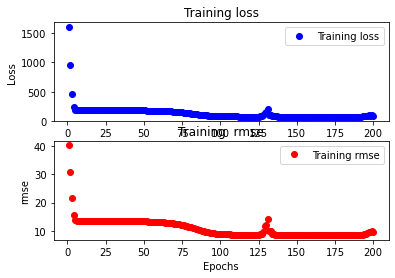

In [6]:

### history에서 loss key를 가지는 값들만 추출
loss = result.history['loss']
### loss를 그래프화
epochs = range(1, len(loss) + 1)
plt.subplot(211)  ## 2x1 개의 그래프 중에 1번째
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### history에서 mean_absolute_error key를 가지는 값들만 추출
mae = result.history['root_mean_squared_error']
epochs = range(1, len(mae) + 1)
### mean_absolute_error 그래프화
plt.subplot(212)  ## 2x1 개의 그래프 중에 2번째
plt.plot(epochs, mae, 'ro', label='Training rmse')
plt.title('Training  rmse')
plt.xlabel('Epochs')
plt.ylabel('rmse')
plt.legend()

print("\n Test rmse: %.4f" % (model.evaluate(normed_train_data, label_data)[1]))

plt.show()

In [7]:
normed_train_data

,house age,distance to the nearest MRT station,number of convenience stores,latitude,longitude
0,1.254111,-0.791537,2.004982,1.124070,0.448220
1,0.156896,-0.615866,1.665488,0.911342,0.400654
2,-0.387322,-0.413515,0.307513,1.485063,0.687352
3,-0.387322,-0.413515,0.307513,1.485063,0.687352
4,-1.115873,-0.549332,0.307513,0.833180,0.592220
...,...,...,...,...,...
409,-0.352211,2.375490,-1.389957,-2.214314,-1.925506
410,-1.063206,-0.787118,1.665488,0.427062,0.634573
411,0.095452,-0.549014,0.986500,0.821899,0.423460
412,-0.843763,-0.775745,0.307513,-0.184532,0.476238


In [ ]:
sns.pairplot(normed_train_data[["house age", "distance to the nearest MRT station", "number of convenience stores", "latitude", "longitude"]], diag_kind="kde")
plt.show()